# **Balanced Risk Set Matching (BRSM) Implementation**


### **Authors:**
- **Oncines**, Myles Kim Q.
- **Pimentel**, Chelsea Rose J.  

-----


### Balanced Risk Set Matching - Implementation

# Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Step 1: Generate Synthetic Dataset

In [20]:
np.random.seed(42)  # Ensuring reproducibility
data_size = 250  # Adjust dataset size

data = pd.DataFrame({
    'ID': np.arange(data_size),
    'symptom_score': np.random.randint(1, 11, data_size),
    'urgency_level': np.random.randint(1, 11, data_size),
    'visit_frequency': np.random.randint(1, 11, data_size),
    'age': np.random.randint(18, 85, data_size),
    'BMI': np.random.uniform(18.5, 35, data_size),
    'risk_category': np.random.choice(['Low', 'Medium', 'High'], data_size),
    'months_since_first_visit': np.random.randint(1, 36, data_size),
    'treatment_status': np.random.choice([0, 1], size=data_size, p=[0.6, 0.4])
})

print("Sample Data:")
print(data.head())

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Sample Data:
   ID  symptom_score  urgency_level  visit_frequency  age        BMI  \
0   0              7              8                9   22  25.339326   
1   1              4              4                1   59  32.748049   
2   2              8              6                1   78  33.728844   
3   3              5              8                4   39  26.184052   
4   4              7              4                9   38  26.433810   

  risk_category  months_since_first_visit  treatment_status  
0           Low                        25                 1  
1        Medium                        17                 1  
2          High                        29                 1  
3           Low                         8                 1  
4          High                        15                 0  


# Step 2: Compute Mahalanobis Distance

In [21]:
feature_cols = ['symptom_score', 'urgency_level', 'visit_frequency', 'age', 'BMI']
cov_matrix = np.cov(data[feature_cols].values.T)
inverse_cov = np.linalg.inv(cov_matrix)

treated_group = data[data['treatment_status'] == 1].reset_index(drop=True)
control_group = data[data['treatment_status'] == 0].reset_index(drop=True)

def compute_mahalanobis(X, Y, VI):
    return cdist(X, Y, metric='mahalanobis', VI=VI)

distance_matrix = compute_mahalanobis(
    treated_group[feature_cols], control_group[feature_cols], inverse_cov
)

# Step 3: Optimal Matching Using Network Graphs

In [22]:
G = nx.Graph()
for i, treated_id in enumerate(treated_group['ID']):
    for j, control_id in enumerate(control_group['ID']):
        G.add_edge(f'T{i}', f'C{j}', weight=distance_matrix[i, j])

matched_pairs = nx.algorithms.matching.min_weight_matching(G)
matched_df = pd.DataFrame({
    'treated_patient': [int(t[1:]) for t, c in matched_pairs],
    'control_patient': [int(c[1:]) for t, c in matched_pairs],
    'match_distance': [G[t][c]['weight'] for t, c in matched_pairs]
})

print("Matched Sample:")
print(matched_df.head())

Matched Sample:
   treated_patient  control_patient  match_distance
0              148               68        0.532990
1               26               26        0.984227
2               74               20        1.020495
3               10               98        0.790609
4               68               14        0.821974


# Step 4: Visualizing Matched Distance Distribution

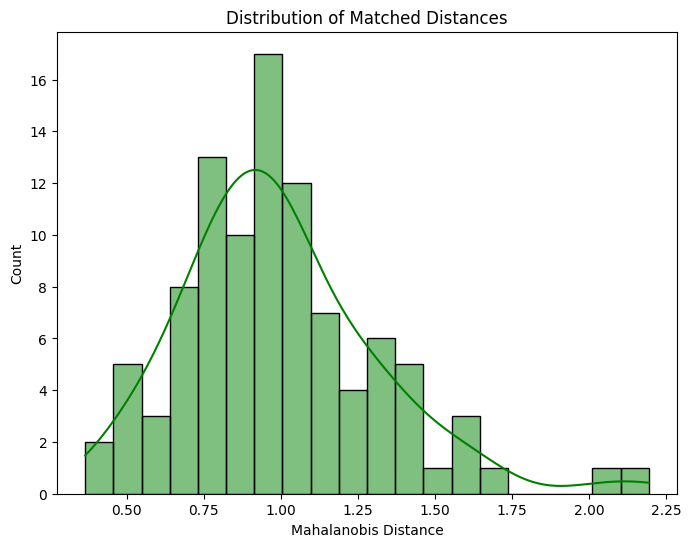

In [23]:
plt.figure(figsize=(8, 6))
sns.histplot(matched_df['match_distance'], bins=20, kde=True, color='green')
plt.title("Distribution of Matched Distances")
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Count")
plt.show()

# Step 5: Sensitivity Analysis (Checking Balance in Key Variables)

In [25]:
def balance_check(feature):
    return treated_group[feature].mean(), control_group.loc[matched_df['control_patient'], feature].mean()

balance_results = {feature: balance_check(feature) for feature in feature_cols}

balance_df = pd.DataFrame(balance_results, index=["Treated", "Control"]).T
print("\nBalance Check:")
print(balance_df)


Balance Check:
                   Treated    Control
symptom_score     5.535354   5.767677
urgency_level     5.505051   5.040404
visit_frequency   5.272727   5.505051
age              46.111111  51.868687
BMI              27.118636  27.182395


# Step 6: Visualizing Balance Comparison

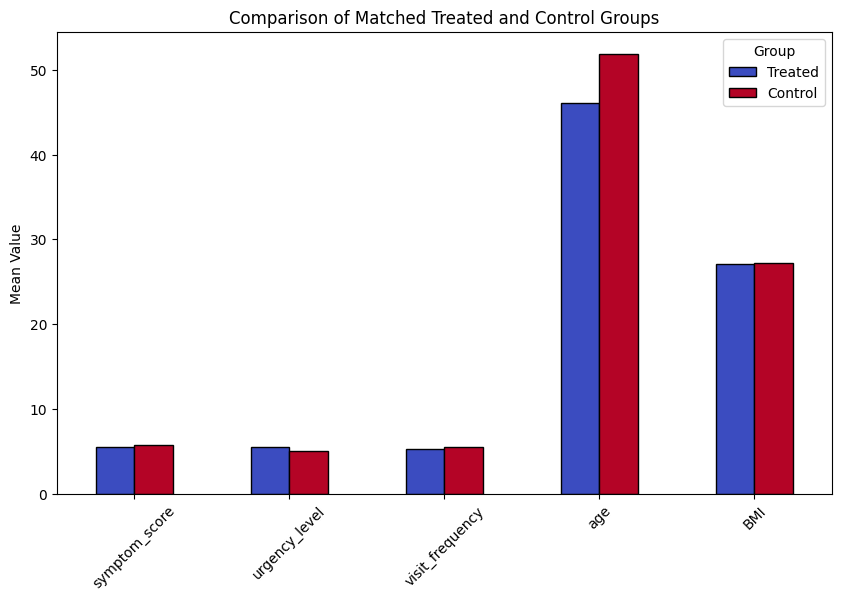

In [24]:
balance_df.plot(kind='bar', figsize=(10, 6), colormap='coolwarm', edgecolor='black')
plt.title("Comparison of Matched Treated and Control Groups")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.legend(title="Group")
plt.show()
